In [71]:
import numpy as np
import pandas as pd
import glob as gb
import re
import matplotlib.pyplot as plt
import pprint as pp
import os
from scipy import signal
from cycler import cycler

%matplotlib notebook

In [75]:
# Dataframe initialise
files = gb.glob('./Spectrum/PlottingData/*.txt')

def getSample(file):
    # Sample
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    return sample

def getSampleNo(file):
    # Sample
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    return int(sample[1:])

# Get samples from file names
sample_list=[getSample(x) for x in files]

# Index
index = [int(x[1:]) for x in sample_list]

d = {'sample' : sample_list}

df = pd.DataFrame(d, index=index)
df.sort_index(inplace=True)
df = df.set_index('sample')

In [76]:
# Create colormap for plotting
n = len(sample_list) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# Spectrum

In [78]:
# Add spectrum data to df
imax = []
itot = []
sample = []
for f in files:
    
    # Load data
    spectrumData = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    wavelength = spectrumData[:,0]
    intensity = spectrumData[:,1]
    
    # Store max intensity to dataframe
    imax.append(max(intensity))
    itot.append(sum(intensity))
    sample.append(getSample(f))


df['MaxIntensity'] = pd.Series(imax, index=sample)  
df['TotalIntensity'] = pd.Series(itot, index=sample)

,MaxIntensity,TotalIntensity
sample,,
T1,168200.0,15500290.0
T2,165300.0,15583850.0
T3,132600.0,14499530.0
T4,160600.0,16723680.0
T5,119400.0,14065800.0


<IPython.core.display.Javascript object>


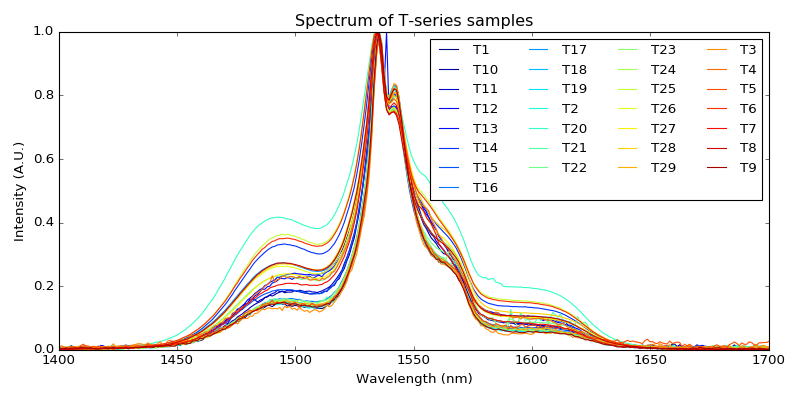

In [100]:
# Plot all spectrum
fig, ax = plt.subplots(figsize=(10,5))

for f in files:
    # Load data
    spectrumData = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    wavelength = spectrumData[:,0]
    intensity = spectrumData[:,1]
    
    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    # Sample
    sample = getSample(f)
    
    ax.plot(wavelength, intensity, label=sample)
    
plt.xlim(min(wavelength),max(wavelength))
plt.legend(prop={'size': 12}, ncol=4, loc='best')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (A.U.)')
plt.title('Spectrum of T-series samples')
plt.tight_layout()
plt.savefig('all_spectrum.png', dpi=500)

<IPython.core.display.Javascript object>


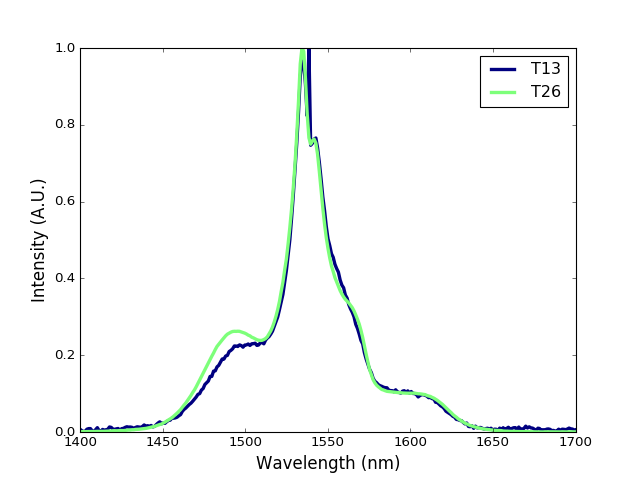

1.0
1.0


(1399.95, 1700.25)

In [99]:
# Plot single Spectrum data file
a = ['T13.', 'T26.']

# Plot data
fig, ax = plt.subplots()

# Set colour cycle for lines
n = len(a) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
ax.set_prop_cycle(cycler('color', new_colors))

for f in files:
    if any(x in f for x in a):
        # Load data
        spectrumData = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
        wavelength = spectrumData[:,0]
        intensity = spectrumData[:,1]

#         Normalise
        intensity -= min(intensity)
        intensity /= max(intensity)

        print(max(intensity))
        
        # Sample
        sample = os.path.basename(f)
        sample = os.path.splitext(sample)[0]
        
        ax.plot(wavelength, intensity, label=sample, linewidth=3)
        peakind = signal.find_peaks_cwt(intensity,np.arange(1,10))
    
plt.legend()
plt.xlabel('Wavelength (nm)', size=15)
plt.ylabel('Intensity (A.U.)', size=15)
plt.yticks(size=12); plt.xticks(size=12)
plt.xlim(min(wavelength),max(wavelength))
# plt.savefig('spectrum_T2_T26.png', dpi=700)

In [11]:
# Find peaks and FWHM... still need to implement
wavelength[peakind]

array([ 1410.45,  1487.1 ,  1539.6 ,  1613.1 ,  1690.8 ])

# Plot Lifetimes

In [116]:
# Lifetime function
from scipy.optimize import curve_fit

def model_func(t, a, b, c):
    return a*np.exp(-t/b)+c

def getLifetime(time, intensity, f):
    try:
        guess = [max(intensity), 10, min(intensity)]
        popt, pcov = curve_fit(model_func, time, intensity, guess)
        return popt[1]
    except:
        print(f + ' did not fit a single exp :(')
        return np.NaN

In [117]:
pump = 0.1  # ms

files = gb.glob('./Lifetime/*.txt')
# Remove certain files from list (depending on what pump you want)
files = [ x for x in files if '_' not in x ]
files = sorted(files, key=lambda x: getSampleNo(x))

tau = []
sample = []
for f in files:
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    time = data[:,0]/1E6  # Convert to ms
    intensity = data[:,1]
    
    # Sample
    sample.append(getSample(f))

    # Get lifetimes
    time = time - pump
    ind = np.where(time >= pump)
    tau.append(getLifetime(time[ind], intensity[ind], f))

df['Lifetime'] = pd.Series(tau, index=sample)  

## Plot decay

<IPython.core.display.Javascript object>


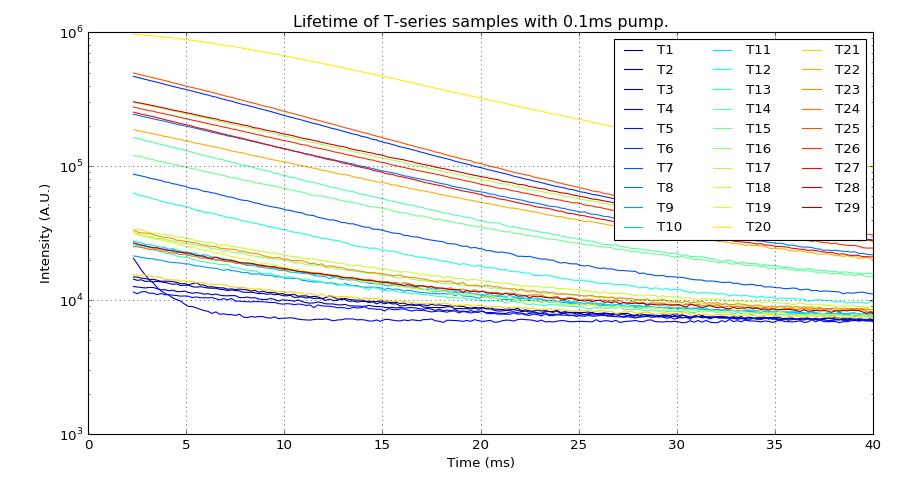

In [125]:
# Plot data
fig, ax = plt.subplots()
for f in files:
    # Load data
    spectrumData = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    time = spectrumData[:,0]/1E6  # Convert to ms
    intensity = spectrumData[:,1]
    
    time = time - pump
    ax.semilogy(time, intensity, label=getSample(f))

plt.legend(prop={'size': 12}, ncol=3, loc='best')
plt.xlim(0, 40)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.title('Lifetime of T-series samples with %sms pump.' % pump)
plt.tight_layout()
plt.grid()
# fig.savefig('spectrum.png')

# Pandas Dataframe

In [126]:
df.head()

,MaxIntensity,TotalIntensity,Lifetime
sample,,,
T1,168200.0,15500290.0,12.582230
T2,165300.0,15583850.0,12.478842
T3,132600.0,14499530.0,12.041918
T4,160600.0,16723680.0,1.541382
T5,119400.0,14065800.0,12.971974


In [128]:
# Save Dataframe
df.to_csv('Spectrum_dataframe.csv')
# To load
# pd.read_csv('dataframe.csv', index_col=0) 